# Collaborative filtering

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import MiniBatchNMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
ratings = pd.read_csv("../data/movielens/ratings.csv")

## Preprocessing

In [3]:
ratings = ratings.drop(columns="timestamp")
ratings.head(2)

,user_id,movie_id,rating
0,1,1,4.0
1,1,110,4.0


In [4]:
n_users = ratings["user_id"].nunique()
n_movies = ratings["movie_id"].nunique()
n_ratings = ratings["rating"].shape[0]

print(f"There are {n_users} users in the dataset.")
print(f"There are {n_movies} movies in the dataset.")
print(f"There are {n_ratings} ratings in the dataset.")

There are 330975 users in the dataset.
There are 83239 movies in the dataset.
There are 33832162 ratings in the dataset.


### Filtering

In [5]:
# Finding stats on user ratings
ratings_per_user = ratings.groupby("user_id").size()
print(f"Average ratings per user: {ratings_per_user.mean():.2f}")
print(f"Median ratings per user: {ratings_per_user.median():.2f}")
print(f"Min ratings: {ratings_per_user.min()}")
print(f"Max ratings: {ratings_per_user.max()}")
print()
mean_user_rating = ratings_per_user.mean()

# Filtering out users with less than the average number of ratings
user_rating_counts = ratings["user_id"].value_counts()
average_users = user_rating_counts[user_rating_counts >= mean_user_rating].index
filtered_ratings = ratings[ratings["user_id"].isin(average_users)]

# Reviewing the filtered dataset
n_users_filtered = filtered_ratings["user_id"].nunique()
print(f"There are now {n_users_filtered} users in the dataset. {n_users_filtered / n_users:.2%} of the original dataset.")

Average ratings per user: 102.22
Median ratings per user: 31.00
Min ratings: 1
Max ratings: 33332

There are now 79469 users in the dataset. 24.01% of the original dataset.


In [6]:
# Finding stats on movie ratings
ratings_per_movie = ratings.groupby("movie_id").size()
print(f"Average ratings per movie: {ratings_per_movie.mean():.2f}")
print(f"Median ratings per movie: {ratings_per_movie.median():.2f}")
print(f"Min ratings: {ratings_per_movie.min()}")
print(f"Max ratings: {ratings_per_movie.max()}")
print()

# Filtering out movies with few ratings
movie_rating_counts = filtered_ratings["movie_id"].value_counts()
average_movies = movie_rating_counts[movie_rating_counts >= 25].index
filtered_ratings = filtered_ratings[filtered_ratings["movie_id"].isin(average_movies)]

# Reviewing the filtered dataset
n_movies_filtered = filtered_ratings["movie_id"].nunique()
print(f"There are now {n_movies_filtered} movies in the dataset. {n_movies_filtered / n_movies:.2%} of the original dataset.")

Average ratings per movie: 406.45
Median ratings per movie: 5.00
Min ratings: 1
Max ratings: 122296

There are now 20821 movies in the dataset. 25.01% of the original dataset.


In [7]:
# Reviewing the number of ratings
n_ratings_filtered = filtered_ratings["rating"].shape[0]
print(f"There are now {n_ratings_filtered} ratings in the dataset. {n_ratings_filtered / n_ratings:.2%} of the original dataset.")

There are now 26167161 ratings in the dataset. 77.34% of the original dataset.


In [8]:
ratings = filtered_ratings

### Scaling user ratings

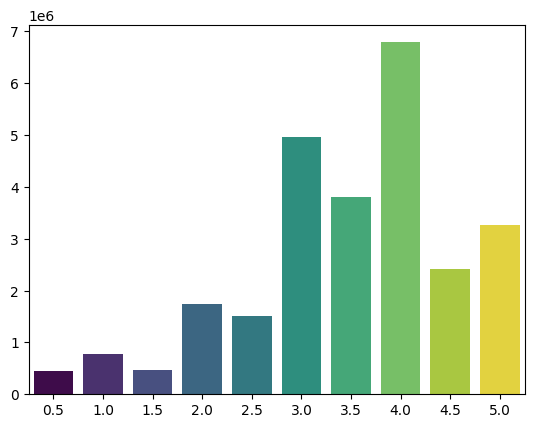

In [10]:
# Visualising the rating distribution
rating_distribution = ratings["rating"].value_counts().to_dict()
rating_distribution = dict(sorted(rating_distribution.items()))
sns.barplot(x=list(rating_distribution.keys()), y=list(rating_distribution.values()), hue=list(rating_distribution.keys()), palette="viridis", legend=False);

In [9]:
def scaler(df):
    """
    Scales (standardising and normalising) the ratings of each user. 
    Standardising is necessary since the ratings overall are not normally distributed 
    and some users might always rate high, low or with a large variance. 
    Normalising is necessary since matrix factorisation can only handle non-negative values.

    Arguments:
    df -- DataFrame with user_id, movie_id and rating columns

    Returns:
    df -- DataFrame with user_id, movie_id and scaled rating columns
    """
    df_collection = []
    for user, user_df in df.groupby("user_id"): 
        rating_values = user_df["rating"].values
        mean = np.mean(rating_values)
        std = np.std(rating_values)
        if std < 1e-10:
            user_df["rating"]=0.5 # if std is 0, set rating to 0.5 which is an average rating once ratings are normalised (0 to 1)
        else:
            std_values = (rating_values - mean) / std
            min_std = np.min(std_values)
            max_std = np.max(std_values)
            user_df["rating"] = (std_values - min_std) / (max_std - min_std)
        df_collection.append(user_df) # stores dataframes in a list which are concatenated at the end
    return pd.concat(df_collection)


scaled_ratings = ratings.copy()
scaled_ratings = scaler(scaled_ratings)

In [10]:
scaled_ratings.head(2)

,user_id,movie_id,rating
304,7,1,0.666667
305,7,3,0.333333


In [11]:
ratings = scaled_ratings

### User-movie matrix

In [12]:
# Creating a user-movie matrix using pivot_table() crashes the kernel. 
# I tried creating a sparse matrix (see line below) with user_id, movie_id and rating as rows, columns and values but that resulted in a much larger matrix than users*movies. 
# sparse_matrix = coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"])))
# From my understanding the issue is that the IDs are not contiguous (0, 1, 2, 3 ...) resulting in a shape of max_user_ID*max_movie_ID.
# I asked Claude Sonnet 3.7 to: "Modify the code to create a sparse matrix in the shape of users*movies."

# Get unique user and movie IDs
unique_users = np.sort(ratings["user_id"].unique())
unique_movies = np.sort(ratings["movie_id"].unique())

# Create mappings from original IDs to consecutive indices
user_mapper = {user: i for i, user in enumerate(unique_users)}
movie_mapper = {movie: i for i, movie in enumerate(unique_movies)}

# Recovering the original user and movie IDs
# user???
# movie???

# Map original IDs to indices
rows = np.array([user_mapper[user] for user in ratings["user_id"]])
cols = np.array([movie_mapper[movie] for movie in ratings["movie_id"]])
vals = ratings["rating"].values

# Create the sparse matrix with appropriate shape
rating_matrix = csr_matrix((vals, (rows, cols)), shape=(len(unique_users), len(unique_movies)))

In [13]:
density = rating_matrix.nnz / (rating_matrix.shape[0] * rating_matrix.shape[1])
print(f"Only {density * 100:.3f} % of the matrix contains ratings.") 

Only 1.581 % of the matrix contains ratings.


In [14]:
rating_matrix.shape

(79469, 20821)

## Matrix factorisation

### Find the optimal rank

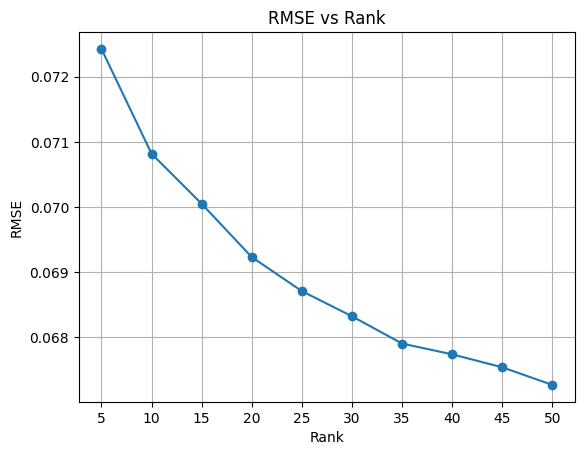

In [25]:
rank_range = range(5, 51, 5)
b = 5000
sample = 1000
RMSE_values = []
user_idxs = np.random.choice(rating_matrix.shape[0], sample, replace=False)
item_idxs = np.random.choice(rating_matrix.shape[1], sample, replace=False)

for n in rank_range:
    model = MiniBatchNMF(
        n_components=n,
        batch_size=b
    )
    W = model.fit_transform(rating_matrix)
    H = model.components_
    V = np.dot(W[user_idxs, :], H[:, item_idxs])
    R = rating_matrix[user_idxs, :][:, item_idxs].toarray()
    RMSE = np.sqrt(mean_squared_error(R, V))
    RMSE_values.append(RMSE)

plt.plot(rank_range, RMSE_values, marker="o")
plt.xlabel("Rank")
plt.ylabel("RMSE")
plt.title("RMSE vs Rank")
plt.xticks(rank_range)
plt.grid()
plt.show()

### Finding the optimal regularisation value

In [ ]:
model = MiniBatchNMF()
params = {
    "alpha_H": [0.01, 0.1, 1],
    "alpha_W": [0.01, 0.1, 1]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
grid_search.fit(V)
print(f"Best parameters: {grid_search.best_params_}")

/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/albotgoodman/coding/repos/machine-learning/.venv/lib/pytho

Best parameters: {'alpha_H': 0.01, 'alpha_W': 0.01}


### MBNMF model

In [15]:
n = 35
b = 5000
a = 0.01

nmf = MiniBatchNMF(n_components=n, batch_size=b, alpha_W=a, alpha_H=a)
W = nmf.fit_transform(rating_matrix)
H = nmf.components_
print(f"Shape of W: {W.shape}")
print(f"Shape of H: {H.shape}")

Shape of W: (79469, 35)
Shape of H: (35, 20821)


## Movie data

In [16]:
movies = pd.read_csv("../data/movielens/movies.csv")
movies["genres"] = movies["genres"].replace("(no genres listed)", np.nan)
movies["genres"] = movies["genres"].str.lower().str.replace("|", " ").str.replace("-", "").str.strip()
movies["year"] = movies["title"].str.extract(r"\((\d{4})\)")
movies["title"] = movies["title"].str.replace(r"\[.*?\]|\(.*?\)", "", regex=True).str.strip()
movies.dropna(how="any", inplace=True) # dropping 7300 NaN values
movies = movies.drop(columns="genres")

In [17]:
movies.shape

(79237, 3)

In [18]:
movies = movies[movies["movie_id"].isin(ratings["movie_id"].unique())]

In [19]:
movies.shape

(20607, 3)

## Recommendations

In [51]:
def get_movie_index(movie_id):
    # Convert original movie_id to the matrix index
    return movie_mapper.get(movie_id)

In [ ]:
def get_similar_movies(movie_id, n_recommendations=5):
    movie_idx = get_movie_index(movie_id)
    if movie_idx is None:
        return "Movie ID not found"
    
    # Get latent factors for target movie
    target_factors = H[:, movie_idx]
    
    # Calculate similarities - directly comparing latent factors
    similarities = []
    for idx in range(H.shape[1]):
        if idx != movie_idx:
            # sim = np.dot(target_factors, H[:, idx]) # Either dot product
            sim = np.dot(target_factors, H[:, idx]) / (np.linalg.norm(target_factors) * np.linalg.norm(H[:, idx])) # Or cosine similarity 
            similarities.append((idx, sim))
    
    # Sort and get top recommendations
    similarities.sort(key=lambda x: x[1], reverse=True)
    similar_indices = [idx for idx, _ in similarities[:n_recommendations]]
    
    # Map back to original IDs
    return [reverse_movie_mapper[idx] for idx in similar_indices]

In [56]:
# Create reverse mappers to convert indices back to IDs
reverse_movie_mapper = {idx: movie_id for movie_id, idx in movie_mapper.items()}

def get_recommendations(movie_id, n_recommendations=5):
    similar_movie_ids = get_similar_movies(movie_id, n_recommendations)
    
    # Get movie details (title, etc.) from the movies dataframe
    recommendations = movies[movies['movie_id'].isin(similar_movie_ids)]
    return recommendations

In [57]:
temp = get_recommendations(1)
temp = temp.drop(columns="movie_id")
temp

,title,year
359,"Lion King, The",1994
580,Aladdin,1992
1070,E.T. the Extra-Terrestrial,1982
2264,"Bug's Life, A",1998
3021,Toy Story 2,1999
